In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os

# DM parameters are fixed throughout this analysis
from dm_params import mx, sv, fx
from utilities import e_low_excess, e_high_excess
from background_models import phi_g_egb_fermi
from finite_clump_vectorized import rho_s_dampe, luminosity, phi_g, phi_e, rho
from finite_clump_vectorized import gamma_ray_extent, line_width_constraint
from finite_clump_vectorized import fermi_point_src_contraint, anisotropy_differential
from utilities import e_high_excess, bins_dampe
from utilities import fermi_psf, fermi_psf_solid_angle
from utilities import rho_max, dn_de_g_ap
from utilities import rho_earth, Hz_to_GeV2_cm3, GeV_to_m_sun, kpc_to_cm, t_universe
from utilities import e_low_aniso_fermi, e_high_aniso_fermi, aniso_fermi
from utilities import colors, mantissa_exp, sci_fmt, log_levels
from utilities import normal_contours, sci_contours, log_contours

# Significance used for line width constraint
n_sigma = 3.
# Photon energy at which to compute fluxes
e_gamma_ref = 230.
# Directory with Ben's probability data files
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"

Compute $\rho_0$ over a $(d, R_b, \gamma)$ grid for the exponential/tidally truncated profile

In [3]:
dist = np.logspace(-3, 0, 10)
r_s = np.logspace(-3, 1, 10)
gamma_exp = np.array([0.28594, 0.450207, 0.577731, 0.689375, 0.794874,
                      0.901285, 1.01681, 1.15728, 1.38515])
dist_mg, r_s_mg, gamma_exp_mg = np.meshgrid(dist, r_s, gamma_exp)

base_path_exp = 'data/exp_gamma_grid/'

$\rho_s$

In [6]:
rho_s_exp = rho_s_dampe(dist_mg, r_s_mg, gamma_exp_mg, "exp")

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  **opt)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assu

$\mathcal{L}$

In [7]:
lum_exp = luminosity(r_s_mg, rho_s_exp, gamma_exp_mg, "exp")

Save results

In [8]:
for var in ["dist", "r_s", "gamma_exp"]:
    np.savetxt(base_path_exp + var + ".csv", eval(var), delimiter=',')

for i, g in enumerate(gamma_exp):
    rho_path = "{:s}rho_s_{}.csv".format(base_path_exp, g)
    np.savetxt(rho_path, rho_s_exp[:, :, i])
    lum_path = "{:s}lum_{}.csv".format(base_path_exp, g)
    np.savetxt(lum_path, lum_exp[:, :, i])

In [11]:
os.system("say 'Done computing over exp grid'")

0

Check $\rho_s$ plots for different values of $\gamma$

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/matplotlib/contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


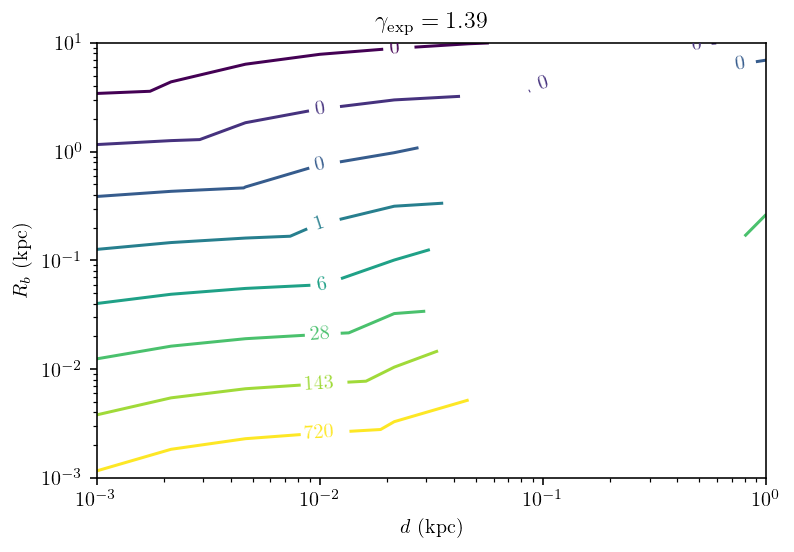

In [19]:
gamma_idx = 8

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.title(r"$\gamma_{\mathrm{exp}} = %.2f$" % gamma_exp[gamma_idx])

normal_contours(dist_mg[:, :, gamma_idx], r_s_mg[:, :, gamma_idx],
                rho_s_exp[:, :, gamma_idx], plt.gca())